# Classificação de Situação de Saúde Pública

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [25]:
# Carregar os dados
data = pd.read_csv('improved_health_data.csv')

data.head()

,garbage,sewage,complaints,population,risk_level,hospital_access,vaccination_rate
0,86,36,53,7010,low,0,0.795166
1,6,64,89,5926,low,0,0.029090
2,22,73,32,7065,low,0,0.118431
3,33,98,19,1634,low,1,0.847879
4,8,74,44,3218,low,0,0.352101


## Pré-processamento

In [26]:
# Codificar a coluna 'risk_level'
data['risk_level'] = data['risk_level'].str.lower()
label_encoder = LabelEncoder()
data['risk_level'] = label_encoder.fit_transform(data['risk_level'])

data.head()

,garbage,sewage,complaints,population,risk_level,hospital_access,vaccination_rate
0,86,36,53,7010,1,0,0.795166
1,6,64,89,5926,1,0,0.029090
2,22,73,32,7065,1,0,0.118431
3,33,98,19,1634,1,1,0.847879
4,8,74,44,3218,1,0,0.352101


## Dividir os dados em features e target

In [27]:
X = data.drop('risk_level', axis=1)
y = data['risk_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE apenas no conjunto de treino
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Normalizar os dados com StandardScaler ajustado apenas no treino
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Seleção de features com SelectKBest
selector = SelectKBest(score_func=f_classif, k='all')
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

## Treinar modelos de classificação

In [28]:
# Definir os modelos e hiperparâmetros para GridSearchCV
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()
}

param_grids = {
    "Decision Tree": {'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]},
    "KNN": {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    "SVM": {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
}

results = {}
accuracies = []

# Treinar, prever e avaliar com GridSearchCV
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    
    results[model_name] = {
        "accuracy": accuracy,
        "conf_matrix": conf_matrix,
        "class_report": class_report,
        "best_params": grid_search.best_params_,
        "y_pred": y_pred,
        "best_model": best_model
    }
    
    accuracies.append((model_name, accuracy))

## Avaliação dos modelos

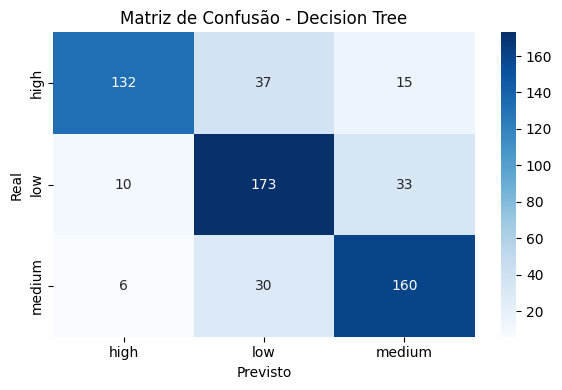

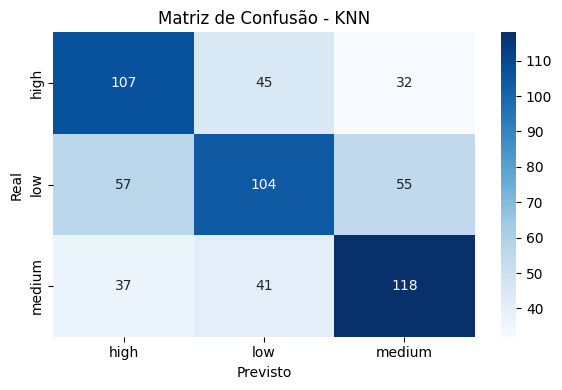

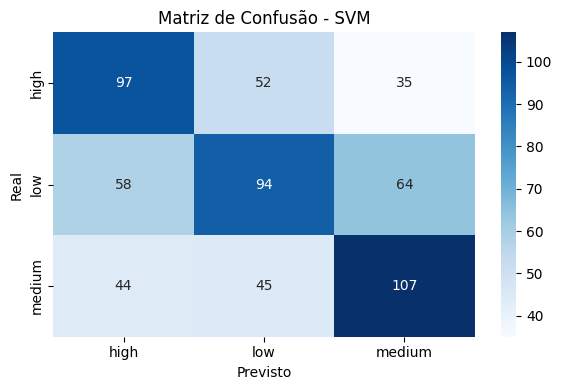

In [29]:
# Plotar matriz de confusão para cada modelo
for model_name, result in results.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(result['conf_matrix'], annot=True, fmt="d", cmap="Blues", 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

C:\Users\laura\AppData\Local\Temp\ipykernel_8684\481333759.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracy_values, palette="Set2")


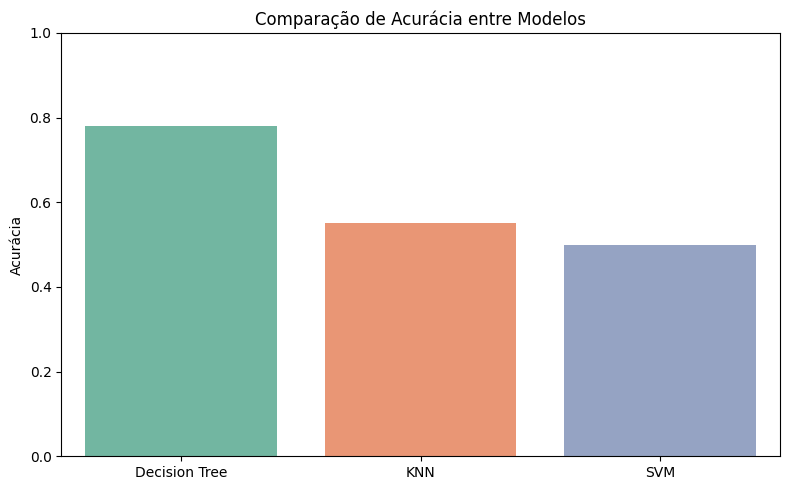

In [30]:
# Gráfico de comparação de acurácias
model_names = [name for name, acc in accuracies]
accuracy_values = [acc for name, acc in accuracies]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracy_values, palette="Set2")
plt.ylabel("Acurácia")
plt.title("Comparação de Acurácia entre Modelos")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [31]:
# Imprimir resultados textuais
for model_name, result in results.items():
    print(f"Modelo: {model_name}")
    print(f"Acurácia: {result['accuracy']:.2f}")
    print(f"Melhores Hiperparâmetros: {result['best_params']}")
    print("Relatório de Classificação:")
    print(result['class_report'])
    print("\n")

Modelo: Decision Tree
Acurácia: 0.78
Melhores Hiperparâmetros: {'max_depth': 15, 'min_samples_split': 2}
Relatório de Classificação:
              precision    recall  f1-score   support

        high       0.89      0.72      0.80       184
         low       0.72      0.80      0.76       216
      medium       0.77      0.82      0.79       196

    accuracy                           0.78       596
   macro avg       0.79      0.78      0.78       596
weighted avg       0.79      0.78      0.78       596



Modelo: KNN
Acurácia: 0.55
Melhores Hiperparâmetros: {'n_neighbors': 5, 'weights': 'distance'}
Relatório de Classificação:
              precision    recall  f1-score   support

        high       0.53      0.58      0.56       184
         low       0.55      0.48      0.51       216
      medium       0.58      0.60      0.59       196

    accuracy                           0.55       596
   macro avg       0.55      0.56      0.55       596
weighted avg       0.55      0.55  

In [32]:
# Salvar o melhor modelo usando joblib
best_model_name, best_accuracy = max(accuracies, key=lambda x: x[1])
best_model = results[best_model_name]["best_model"]
joblib.dump(best_model, 'best_health_model.joblib')
joblib.dump(label_encoder, 'label_encoder_health.joblib')
joblib.dump({
    "model_name": best_model_name,
    "best_params": results[best_model_name]["best_params"]
}, "best_health_model_info.joblib")
print(f"Modelo {best_model_name} salvo como 'best_health_model.joblib' com acurácia de {best_accuracy:.2f}.")

Modelo Decision Tree salvo como 'best_health_model.joblib' com acurácia de 0.78.



## Técnicas Utilizadas

### 1. Pré-processamento de Dados
- **Leitura do dataset** `improved_health_data.csv`.
- **Padronização de rótulos** da coluna `risk_level` para letras minúsculas.
- **Codificação de rótulos** com `LabelEncoder` para transformar categorias em valores numéricos.

### 2. Divisão de Dados
- Separação em **variáveis independentes (X)** e **variável alvo (y)**.
- Divisão em **conjuntos de treino e teste** com `train_test_split`.

### 3. Balanceamento de Classes
- Aplicação de **SMOTE (Synthetic Minority Over-sampling Technique)** para balancear as classes no conjunto de treino.

### 4. Normalização
- Uso de `StandardScaler` para padronizar os dados com média 0 e desvio padrão 1.
- O scaler é ajustado apenas no conjunto de treino e aplicado ao teste.

### 5. Seleção de Atributos
- Uso de `SelectKBest` com `f_classif` para selecionar as melhores features com base em análise univariada.

---

##  Modelos Utilizados

### Modelos testados com `GridSearchCV`:
- **Decision Tree**
- **K-Nearest Neighbors (KNN)**
- **Support Vector Machine (SVM)**

### Hiperparâmetros otimizados:
- **Decision Tree**: `max_depth`, `min_samples_split`
- **KNN**: `n_neighbors`, `weights`
- **SVM**: `C`, `kernel`


##  Melhorias Futuras

- Testar modelos adicionais como **Random Forest**, **Gradient Boosting**, ou **XGBoost**.
- Aplicar **validação cruzada estratificada** para maior robustez.
- Explorar **engenharia de atributos** com interações entre variáveis.
- Avaliar o impacto de **redução de dimensionalidade** (ex: PCA).
- Implementar **explicabilidade de modelos** com SHAP ou LIME.
